## Coprocessor architectures

![](https://en.wikichip.org/w/images/0/06/summit_single-node.svg)

* CUDA devices (NVIDIA)
  * Programmable via **CUDA**, OpenACC, OpenMP-5, OpenCL, HIP->CUDA, SYCL->CUDA
  * Example machine: [OLCF Summit](https://en.wikichip.org/wiki/supercomputers/summit) (details from [user guide](https://www.olcf.ornl.gov/for-users/system-user-guides/summit/summit-user-guide/))
* ROCm devices (AMD)
  * Programmable via **HIP**, OpenMP-5, OpenCL, SYCL->HIP
  * Example machine: [OLCF Frontier](https://www.olcf.ornl.gov/wp-content/uploads/2019/05/frontier_specsheet_v4.pdf)
* Intel X GPUs
  * Programmable via **SYCL**, OpenMP-5, OpenCL?
  * Example machine: [ALCF Aurora/A21](https://aurora.alcf.anl.gov/)
* Upcoming non-coprocessor Supercomputers
  * [RIKEN Fugaku (Post-K)](https://www.hpcwire.com/2019/05/23/riken-post-k-supercomputer-named-after-japans-tallest-peak/)
  * [TACC Frontera](https://www.tacc.utexas.edu/systems/frontera)

## Fundamental capabilities

In [40]:
from io import StringIO
import pandas
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

data = StringIO("""
package,cores,lanes/core,clock (MHz),peak (GF),bandwidth (GB/s),TDP (W),MSRP
Xeon 8280,28,8,2700,2400,141,205,10000
NVIDIA V100,80,64,1455,7800,900,300,10664
AMD MI60,64,64,1800,7362,1024,300,
AMD Rome,64,4,2000,2048,205,200,6450
""")

df = pandas.read_csv(data, index_col='package')
df

,cores,lanes/core,clock (MHz),peak (GF),bandwidth (GB/s),TDP (W),MSRP
package,,,,,,,
Xeon 8280,28,8,2700,2400,141,205,10000.0
NVIDIA V100,80,64,1455,7800,900,300,10664.0
AMD MI60,64,64,1800,7362,1024,300,NaN
AMD Rome,64,4,2000,2048,205,200,6450.0


### [Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law) for energy efficiency

In [22]:
df['efficiency (GF/W)'] = df['peak (GF)'] / df['TDP (W)']
df['efficiency (GF/W)']

package
Xeon 8280      11.707317
NVIDIA V100    26.000000
AMD MI60       24.540000
AMD Rome       10.240000
Name: efficiency (GF/W), dtype: float64

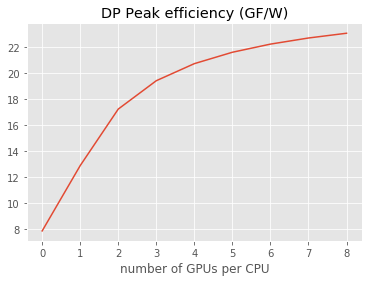

In [53]:
ngpu = np.arange(0, 9)
overhead = 100 # Power supply, DRAM, disk, etc.
peak = (ngpu == 0)*df.loc['Xeon 8280']['peak (GF)'] + ngpu*df.loc['NVIDIA V100']['peak (GF)']
tdp = overhead + df.loc['Xeon 8280']['TDP (W)'] + ngpu*df.loc['NVIDIA V100']['TDP (W)']
plt.plot(ngpu, peak / tdp)
plt.xlabel('number of GPUs per CPU')
plt.title('DP Peak efficiency (GF/W)');

#### Compare to [Green 500 list](https://www.top500.org/green500/lists/2019/06/)
* [#1 system](https://www.top500.org/system/179166) is **15.1 GF/W** (2x Xeon E5-2698v4, 8x V100)
* [#2 system](https://www.top500.org/system/179397) (Summit) is **14.7 GF/W** (2x Power9, 6x V100)
* [#27 system](https://www.top500.org/system/179683) is **5.8 GF/W** on Xeon 6248 (no GPU)

### Amdahl for cost efficiency

In [43]:
df['cost (GF/$)'] = df['peak (GF)'] / df['MSRP']
df['cost (GF/$)']

package
Xeon 8280      0.240000
NVIDIA V100    0.731433
AMD MI60            NaN
AMD Rome       0.317519
Name: cost (GF/$), dtype: float64

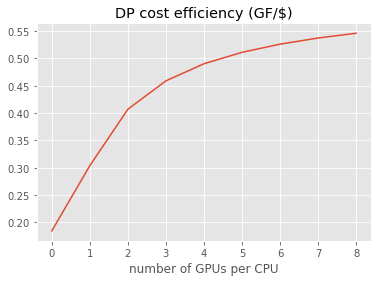

In [54]:
overhead = 3000 + 2000*ngpu # power supply, memory, cooling, maintenance
cost = overhead + df.loc['Xeon 8280']['MSRP'] + ngpu*df.loc['NVIDIA V100']['MSRP']
plt.plot(ngpu, peak / cost)
plt.xlabel('number of GPUs per CPU')
plt.title('DP cost efficiency (GF/$)');

### What fraction of datacenter cost goes to the power bill?

* OLCF Summit is reportedly a \$200M machine.
* What if we just buy the GPUs at retail?
  * 256 racks
  * 18 nodes per rack
  * 6 GPUs per node
  * V100 MSRP of about $10k

In [49]:
256 * 18 * 6 * 10e3 / 1e6 # millions

276.48

* Rule of thumb: $ \lesssim \$1M $ per MW-year
* We know Summit is a 13 MW facility
* Check [industrial electricity rates](https://www.electricitylocal.com/states/tennessee/knoxville/)
![](knoxville-electricity.png)

In [50]:
.0638 * 24 * 365

558.8879999999999

![](olcf-4-foia.png)

## Programming models

* Directives
  * [OpenMP-5](https://www.openmp.org/resources/refguides/)
  * [OpenACC](https://www.openacc.org/)

```c
#pragma acc data copy(A) create(Anew)
while ( error > tol  &&  iter  <  iter_max )  {
  error = 0.0;
#pragma acc kernels {
#pragma acc loop independent collapse(2)
  for (  int  j = 1; j < n-1;  j++ )  {
    for (  int  i = 1; i < m-1; i++ )  {
       Anew [j] [i] = 0.25 * ( A [j] [i+1] + A [j] [i-1] +
                                      A [j-1] [i] + A [j+1] [i]);
       error = max ( error, fabs (Anew [j] [i] - A [j] [i]));
      }
    }
  } 
}
```
Comparison slides: [Is OpenMP 4.5 Target Off-load Ready for Real Life? A Case Study of Three Benchmark Kernels (2018)](https://openmpcon.org/wp-content/uploads/2018_Session1_Diaz.pdf)
  
* Thread "kernel" and control
  * [CUDA](https://devblogs.nvidia.com/even-easier-introduction-cuda/)
  * [HIP](https://rocm-documentation.readthedocs.io/en/latest/Programming_Guides/HIP-GUIDE.html) ([video](https://vimeo.com/channels/olcftraining/359154970))
* C++ templated
  * [SYCL](https://www.khronos.org/sycl/)
  * [Kokkos](https://github.com/kokkos/kokkos)
  * [Raja](https://raja.readthedocs.io/en/master/)